# ML Group Project

## Data Load and Exploratory Analysis

In [116]:
#Need to download vecstack in environment
# @misc{vecstack2016,
#        author = {Igor Ivanov},
#        title = {Vecstack},
#        year = {2016},
#        publisher = {GitHub},
#        howpublished = {\url{https://github.com/vecxoz/vecstack}},
# }

import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap
from dateutil.parser import parse
from sklearn.exceptions import ConvergenceWarning
import statistics as stat
import numpy as np
import pandas as pd
import Helper_Function as hf #File with custom-built functions
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.metrics import classification_report, roc_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from vecstack import StackingTransformer
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)

#Set needed file paths
file_path_1 = '/Users/andrewmartinez/Documents/MBD/Machine Learning II/Group Project/Labels.csv'
file_path_2 = '/Users/andrewmartinez/Documents/MBD/Machine Learning II/Group Project/Train.csv'
file_path_3 = '/Users/andrewmartinez/Documents/MBD/Machine Learning II/Group Project/test.csv'

#Load labels, train data and test data
labels = hf.read_data(file_path_1)
raw_df = hf.read_data(file_path_2)
raw_test_df = hf.read_data(file_path_3)

#External Data
pop_df = pd.read_excel('External_features.xls', sheet_name = 0)
weather_df = pd.read_excel('External_features.xls', sheet_name = 1)

raw_df.describe(include = 'all')

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,59400.000000,59400.000000,59400,59400,59400.000000,59400,59400.000000,5.940000e+04,59400,59400.000000,...,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,NaN,NaN,356,1898,NaN,2146,NaN,NaN,37400,NaN,...,7,8,6,5,5,10,7,3,7,6
top,NaN,NaN,3/15/11,Government Of Tanzania,NaN,DWE,NaN,NaN,none,NaN,...,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
freq,NaN,NaN,572,9084,NaN,17402,NaN,NaN,3563,NaN,...,25348,50818,50818,33186,33186,17021,17021,45794,28522,34625
mean,37115.131768,317.650385,NaN,NaN,668.297239,NaN,34.077427,-5.706033e+00,NaN,0.474141,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,21453.128371,2997.574558,NaN,NaN,693.116350,NaN,6.567432,2.946019e+00,NaN,12.236230,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.000000,NaN,NaN,-90.000000,NaN,0.000000,-1.164944e+01,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,18519.750000,0.000000,NaN,NaN,0.000000,NaN,33.090347,-8.540621e+00,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,37061.500000,0.000000,NaN,NaN,369.000000,NaN,34.908743,-5.021597e+00,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,55656.500000,20.000000,NaN,NaN,1319.250000,NaN,37.178387,-3.326156e+00,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [117]:
#Parse date 
raw_df['date_recorded'] = pd.to_datetime(raw_df['date_recorded'])
raw_df['Year'], raw_df['Month'], raw_df['Day'], raw_df['Day_of_Week'] = raw_df['date_recorded'].dt.year, raw_df['date_recorded'].dt.month,raw_df['date_recorded'].dt.day,raw_df['date_recorded'].dt.weekday

raw_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,Year,Month,Day,Day_of_Week
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2011,3,14,0
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,2013,3,6,2
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,2013,2,25,0
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,2013,1,28,0
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,2011,7,13,2


In [118]:
raw_df.describe(include = 'all')

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,Year,Month,Day,Day_of_Week
count,59400.000000,59400.000000,59400,59400,59400.000000,59400,59400.000000,5.940000e+04,59400,59400.000000,...,59400,59400,59400,59400,59400,59400,59400.000000,59400.000000,59400.000000,59400.000000
unique,NaN,NaN,356,1898,NaN,2146,NaN,NaN,37400,NaN,...,5,10,7,3,7,6,NaN,NaN,NaN,NaN
top,NaN,NaN,2011-03-15 00:00:00,Government Of Tanzania,NaN,DWE,NaN,NaN,none,NaN,...,enough,spring,spring,groundwater,communal standpipe,communal standpipe,NaN,NaN,NaN,NaN
freq,NaN,NaN,572,9084,NaN,17402,NaN,NaN,3563,NaN,...,33186,17021,17021,45794,28522,34625,NaN,NaN,NaN,NaN
first,NaN,NaN,2002-10-14 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2013-12-03 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,37115.131768,317.650385,NaN,NaN,668.297239,NaN,34.077427,-5.706033e+00,NaN,0.474141,...,NaN,NaN,NaN,NaN,NaN,NaN,2011.921667,4.375640,15.621498,2.939933
std,21453.128371,2997.574558,NaN,NaN,693.116350,NaN,6.567432,2.946019e+00,NaN,12.236230,...,NaN,NaN,NaN,NaN,NaN,NaN,0.958758,3.029247,8.687553,1.951627
min,0.000000,0.000000,NaN,NaN,-90.000000,NaN,0.000000,-1.164944e+01,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,2002.000000,1.000000,1.000000,0.000000
25%,18519.750000,0.000000,NaN,NaN,0.000000,NaN,33.090347,-8.540621e+00,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,2011.000000,2.000000,8.000000,1.000000


In [119]:
pop_df.head()

,Name,Abbr.,Status,Capital,Area_KM2,Population2002,Population2012,Increase 2002 - 2012,Pop_Density2012,Population2016
0,Tanzania,TZA,Rep,Dodoma,885803,34443603,44928923,0.304420,50.721123,50144200
1,Arusha,ARU,Reg,Arusha,37576,1288088,1694310,0.315368,45.090217,1890700
2,Dar es Salaam,DAR,Reg,Dar es Salaam,1393,2487288,4364541,0.754739,3133.195262,5465400
3,Dodoma,DOD,Reg,Dodoma,41311,1692025,2083588,0.231417,50.436639,2264500
4,Geita,GEI,Reg,Geita,20054,1337718,1739530,0.300371,86.742296,1932200


In [120]:
weather_df.head()

,Month_num,Month,Temp_Min,Temp_max,rainy_days,total_rain_mm
0,1,January,18.6,29.4,10,133.7
1,2,February,18.6,29.4,9,144.5
2,3,March,18.3,29.0,7,113.9
3,4,April,17.9,28.7,5,57.8
4,5,May,16.5,28.0,1,5.3


In [121]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 44 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null datetime64[ns]
funder                   59400 non-null object
gps_height               59400 non-null int64
installer                59400 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59400 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           59400 non-null 

In [122]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
id              59400 non-null int64
status_group    59400 non-null object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [123]:
pop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 10 columns):
Name                    27 non-null object
Abbr.                   27 non-null object
Status                  27 non-null object
Capital                 27 non-null object
Area_KM2                27 non-null int64
Population2002          27 non-null int64
Population2012          27 non-null int64
Increase 2002 - 2012    27 non-null float64
Pop_Density2012         27 non-null float64
Population2016          27 non-null int64
dtypes: float64(2), int64(4), object(4)
memory usage: 2.2+ KB


In [124]:
pop_df.describe(include = 'all')

,Name,Abbr.,Status,Capital,Area_KM2,Population2002,Population2012,Increase 2002 - 2012,Pop_Density2012,Population2016
count,27,27,27,27,27.000000,2.700000e+01,2.700000e+01,27.000000,27.000000,2.700000e+01
unique,27,27,3,25,NaN,NaN,NaN,NaN,NaN,NaN
top,Shinyanga,LIN,Reg,Dodoma,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,1,25,2,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,65615.037037,2.551378e+06,3.328068e+06,0.281288,192.399592,3.714389e+06
std,NaN,NaN,NaN,NaN,165171.390975,6.391986e+06,8.350869e+06,0.127120,597.003756,9.329334e+06
min,NaN,NaN,NaN,NaN,1393.000000,4.086090e+05,5.646040e+05,0.082708,12.316035,6.426000e+05
25%,NaN,NaN,NaN,NaN,20700.500000,1.009680e+06,1.287212e+06,0.230012,31.711156,1.401050e+06
50%,NaN,NaN,NaN,NaN,32547.000000,1.317879e+06,1.640087e+06,0.271129,50.436639,1.759000e+06
75%,NaN,NaN,NaN,NaN,47591.500000,1.701245e+06,2.173211e+06,0.333781,80.670861,2.389850e+06


In [125]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 6 columns):
Month_num        12 non-null int64
Month            12 non-null object
Temp_Min         12 non-null float64
Temp_max         12 non-null float64
rainy_days       12 non-null int64
total_rain_mm    12 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 656.0+ bytes


In [126]:
weather_df.describe(include = 'all')

,Month_num,Month,Temp_Min,Temp_max,rainy_days,total_rain_mm
count,12.000000,12,12.000000,12.000000,12.000000,12.000000
unique,NaN,12,NaN,NaN,NaN,NaN
top,NaN,July,NaN,NaN,NaN,NaN
freq,NaN,1,NaN,NaN,NaN,NaN
mean,6.500000,NaN,16.783333,28.783333,3.416667,50.575000
std,3.605551,NaN,1.937587,1.314834,3.918681,60.526375
min,1.000000,NaN,13.600000,26.500000,0.000000,0.000000
25%,3.750000,NaN,15.075000,27.825000,0.000000,0.075000
50%,6.500000,NaN,17.400000,29.000000,1.500000,15.750000
75%,9.250000,NaN,18.375000,29.575000,7.000000,116.250000


In [127]:
#Merge with target variable
initial_df = pd.merge(labels, raw_df, how = 'inner', on ='id') 
initial_df.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,Year,Month,Day,Day_of_Week
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2011,3,14,0
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,2013,3,6,2
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,2013,2,25,0
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,2013,1,28,0
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,2011,7,13,2


In [128]:
#Merge with population data set
drop_col_pop = ['Abbr.', 'Capital']
pop_df = pop_df.drop(drop_col_pop, axis = 1)

combined_df = pd.merge(initial_df, pop_df, how = 'left', left_on = 'region', right_on = 'Name')
combined_df.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,Day,Day_of_Week,Name,Status,Area_KM2,Population2002,Population2012,Increase 2002 - 2012,Pop_Density2012,Population2016
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,14,0,Iringa,Reg,35503,840404,941238,0.119983,26.511506,984900
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,6,2,Mara,Reg,21760,1363397,1743830,0.279033,80.139246,1924200
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,25,0,Manyara,Reg,44522,1037605,1425131,0.373481,32.009591,1618000
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,28,0,Mtwara,Reg,16710,1124481,1270854,0.130169,76.053501,1334600
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,13,2,Kagera,Reg,25265,1791451,2458023,0.372085,97.289650,2789600


In [129]:
#Merge with weather data set
drop_col_weather = ['Month']
weather_df = weather_df.drop(drop_col_weather, axis = 1)

combined_df = pd.merge(combined_df, weather_df, how = 'left', left_on = 'Month', 
                       right_on = 'Month_num')
combined_df.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,Population2002,Population2012,Increase 2002 - 2012,Pop_Density2012,Population2016,Month_num,Temp_Min,Temp_max,rainy_days,total_rain_mm
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,840404,941238,0.119983,26.511506,984900,3,18.3,29.0,7,113.9
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,1363397,1743830,0.279033,80.139246,1924200,3,18.3,29.0,7,113.9
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,1037605,1425131,0.373481,32.009591,1618000,2,18.6,29.4,9,144.5
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,1124481,1270854,0.130169,76.053501,1334600,1,18.6,29.4,10,133.7
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,1791451,2458023,0.372085,97.289650,2789600,7,13.6,26.5,0,0.0


In [130]:
hf.null_check(combined_df)

No nulls present.


In [131]:
#Group variables by variable type
nums = hf.numerical_features(combined_df)
cat = hf.categorical_features(combined_df)
bools = hf.boolean_features(combined_df)

print('='*20)
print('Numericals: {:.3f}'.format(len(nums)))
print('Categoricals: {:.3f}'.format(len(cat)))
print('Booleans: {:.3f}'.format(len(bools)))
print('='*20)

Numericals: 25.000
Categoricals: 33.000
Booleans: 2.000


In [132]:
# hf.density_plot(combined_df, 'construction_year', lower_bound = -1000, upper_bound = 2015)

In [133]:
# hf.density_plot(combined_df, 'population', lower_bound = -1000, upper_bound = 2000)

In [134]:
# hf.density_plot(combined_df, 'num_private', lower_bound = -100, upper_bound = 400)

In [135]:
# hf.density_plot(combined_df, 'amount_tsh', lower_bound = -1000, upper_bound = 15000)

In [136]:
# hf.density_plot(combined_df, 'gps_height', lower_bound = -1000, upper_bound = 3500)

In [137]:
# hf.density_plot(combined_df, 'Area_KM2', lower_bound = -10000, upper_bound = 95000)

In [138]:
# hf.density_plot(combined_df, 'Increase 2002 - 2012', lower_bound = -1, upper_bound = 1)

In [139]:
# hf.density_plot(combined_df, 'Pop_Density2012', lower_bound = -1000, upper_bound = 3200)

In [140]:
# hf.density_plot(combined_df, 'Temp_Min', lower_bound = -10, upper_bound = 20)

In [141]:
# hf.density_plot(combined_df, 'rainy_days', lower_bound = -10, upper_bound = 15)

In [142]:
# hf.density_plot(combined_df, 'total_rain_mm', lower_bound = -100, upper_bound = 200)

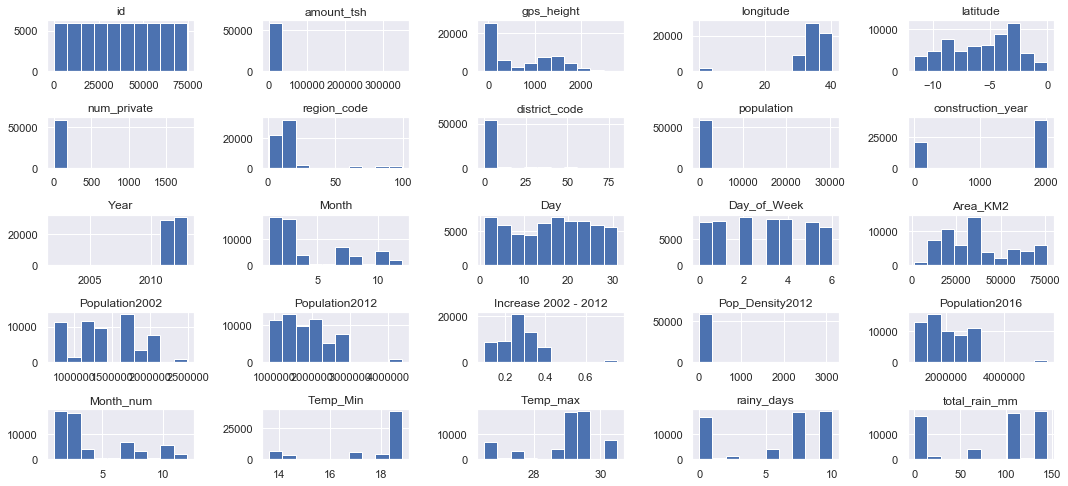

In [143]:
hf.draw_histograms(combined_df, nums, n_rows = 6, n_cols = 5)
scaled_numerics = nums.drop('id')

## Imputing Blanks

In [144]:
#Impute for construction year
combined_df.loc[combined_df['construction_year'] == 0, 'construction_year'] = combined_df['construction_year'].mean()

In [145]:
#Compute population, long and lats averages in districts within regions
region_district_mean = combined_df.groupby(['region','district_code']).mean()

region_district_mean_pop = pd.DataFrame(region_district_mean['population'])
region_district_mean_lat = pd.DataFrame(region_district_mean['latitude'])
region_district_mean_long = pd.DataFrame(region_district_mean['longitude'])

#Map based on district and region (multi-index dataframe)
for row in range(len(combined_df)):
    #Population
    if combined_df.loc[row, 'population'] == 0:
        combined_df.loc[row, 'population'] = region_district_mean_pop.loc[(combined_df.loc[row, 'region'],
                                           combined_df.loc[row, 'district_code']), 'population']
    #Latitude
    if combined_df.loc[row, 'latitude'] == 0:
        combined_df.loc[row, 'latitude'] = region_district_mean_lat.loc[(combined_df.loc[row, 'region'],
                                           combined_df.loc[row, 'district_code']), 'latitude']
    #Longitude
    if combined_df.loc[row, 'longitude'] == 0:
        combined_df.loc[row, 'longitude'] = region_district_mean_long.loc[(combined_df.loc[row, 'region'],
                                           combined_df.loc[row, 'district_code']), 'longitude']
combined_df.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,Population2002,Population2012,Increase 2002 - 2012,Pop_Density2012,Population2016,Month_num,Temp_Min,Temp_max,rainy_days,total_rain_mm
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,840404,941238,0.119983,26.511506,984900,3,18.3,29.0,7,113.9
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,1363397,1743830,0.279033,80.139246,1924200,3,18.3,29.0,7,113.9
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,1037605,1425131,0.373481,32.009591,1618000,2,18.6,29.4,9,144.5
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,1124481,1270854,0.130169,76.053501,1334600,1,18.6,29.4,10,133.7
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,1791451,2458023,0.372085,97.289650,2789600,7,13.6,26.5,0,0.0


In [146]:
#Determine which categorical variables to keep or drop based on number of unique values
up = 20
low = 2

reduced_cat, large_drop, small_drop = hf.drop_categorical(combined_df, cat, upper_bound = up, 
                                                          lower_bound = low)

The following categories have too many unique values: ['subvillage', 'date_recorded', 'lga', 'region', 'installer', 'Name', 'ward', 'scheme_name', 'wpt_name', 'funder']
The following categories have too few unique values: ['recorded_by', 'Status']


In [147]:
#Print distributions of categorical variables
# for col in range(0, len(reduced_cat)):
#     hf.categorical_plot(combined_df, reduced_cat, col) 

In [148]:
total_cat = reduced_cat.copy()
# for var in large_drop:
#     combined_df = hf.set_empty(combined_df, var)
#     total_cat.append(combined_df.columns[len(combined_df.columns)-1])

In [149]:
#Scale the status variable
categorical_df = hf.categorical_to_scale(combined_df, 'status_group')
categorical_df.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,Population2012,Increase 2002 - 2012,Pop_Density2012,Population2016,Month_num,Temp_Min,Temp_max,rainy_days,total_rain_mm,func_band
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,941238,0.119983,26.511506,984900,3,18.3,29.0,7,113.9,2
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,1743830,0.279033,80.139246,1924200,3,18.3,29.0,7,113.9,2
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,1425131,0.373481,32.009591,1618000,2,18.6,29.4,9,144.5,2
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,1270854,0.130169,76.053501,1334600,1,18.6,29.4,10,133.7,0
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,2458023,0.372085,97.289650,2789600,7,13.6,26.5,0,0.0,2


In [150]:
target = 'func_band'
# for var in total_cat:
#     hf.cat_stacked_bar(categorical_df, target ,var)

In [151]:
#Removing based on analysis of similar categoricals
bool_to_drop = ['status_group', 'payment', 'quality_group', 'quantity_group', 'source_type', 
                'extraction_type_group', 'waterpoint_type_group']
reduced_cat = [var for var in reduced_cat if var not in bool_to_drop]

#Removed amount_tsh as majority of values are empty and num_private has no inherent meaning
nums_to_drop = ['id', 'amount_tsh', 'num_private']
scaled_numerics = [var for var in scaled_numerics if var not in nums_to_drop]

vars_to_drop = bool_to_drop + nums_to_drop
categorical_df = categorical_df.drop(vars_to_drop, axis = 1)

In [152]:
#Deal with LGA (rename all entries containing Rural and Urban)
categorical_df.loc[categorical_df['lga'].str.contains(' Rural'),'lga'] = 'rural'
categorical_df.loc[categorical_df['lga'].str.contains(' Urban'),'lga'] = 'urban'

#Otherwise rename as other
searchfor = ['rural', 'urban']
categorical_df.loc[~categorical_df['lga'].str.contains('|'.join(searchfor)),'lga'] = 'other'

reduced_cat.append('lga')
large_drop.remove('lga')

In [153]:
#Deal with extraction type
consolidate = ['cemo','climax', 'other - mkulima/shinyanga', 'other - play pump', 'walimi',
              'other - swn 81','swn 80','india mark ii','india mark iii']

categorical_df.loc[categorical_df['extraction_type'].str.contains('|'.join(consolidate)),
                  'extraction_type'] = 'other motorpump'

In [154]:
#Create dummy variables for categorical variables
encoded_df = hf.onehot_encode(categorical_df, reduced_cat)
encoded_df = encoded_df.drop(large_drop, axis = 1)
encoded_df = encoded_df.drop(small_drop, axis = 1)

#Keep track of boolean variables after encoding
booleans = hf.boolean_features(encoded_df)
encoded_df.head()

,gps_height,longitude,latitude,region_code,district_code,population,construction_year,Year,Month,Day,...,scheme_management_SWC,scheme_management_Trust,scheme_management_VWC,scheme_management_WUA,scheme_management_WUG,scheme_management_Water Board,scheme_management_Water authority,lga_other,lga_rural,lga_urban
0,1390,34.938093,-9.856322,11,5,109.0,1999.000000,2011,3,14,...,0,0,1,0,0,0,0,1,0,0
1,1399,34.698766,-2.147466,20,2,280.0,2010.000000,2013,3,6,...,0,0,0,0,0,0,0,1,0,0
2,686,37.460664,-3.821329,21,4,250.0,2009.000000,2013,2,25,...,0,0,1,0,0,0,0,1,0,0
3,263,38.486161,-11.155298,90,63,58.0,1986.000000,2013,1,28,...,0,0,1,0,0,0,0,1,0,0
4,0,31.130847,-1.825359,18,1,0.0,1300.652475,2011,7,13,...,0,0,0,0,0,0,0,1,0,0


In [155]:
# # Extract the data we're interested in
# lat = encoded_df['latitude'].values
# lon = encoded_df['longitude'].values
# population = encoded_df['population'].values
# scale_target= encoded_df[target].values

# lat_med = stat.median(encoded_df['latitude'].values)
# lon_med = stat.median(encoded_df['longitude'].values)

In [156]:
# # 1. Draw the map background
# fig = plt.figure(figsize=(8, 8))
# m = Basemap(projection='lcc', resolution='h', 
#             lat_0=lat_med, lon_0=lon_med,
#             width=1.3E6, height=1.5E6)
# m.shadedrelief()
# m.drawcoastlines(color='gray')
# m.drawcountries(color='gray')
# m.drawstates(color='gray')

# # 2. scatter city data, with color reflecting well status
# m.scatter(lon, lat, latlon=True, c=scale_target, cmap = 'Reds', alpha=0.5)

# # 3. create colorbar and legend
# plt.colorbar(label=r'$\rm Well Functioning Status}$')
# plt.clim(0, 2)

In [157]:
#Fix skewness and standardized numeric variables
prepared = encoded_df.copy()
prepared[scaled_numerics] = hf.fix_skewness(encoded_df[scaled_numerics])
prepared = hf.standardize(prepared, scaled_numerics)
prepared.head()

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/Users/andrewmartinez/Documents/MBD/Machine Learning II/Group Project/Helper_Function.py:189: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  standardized_numericals = preprocessing.scale(df[numerical_values])
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:193: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


,gps_height,longitude,latitude,region_code,district_code,population,construction_year,Year,Month,Day,...,scheme_management_SWC,scheme_management_Trust,scheme_management_VWC,scheme_management_WUA,scheme_management_WUG,scheme_management_Water Board,scheme_management_Water authority,lga_other,lga_rural,lga_urban
0,1.041252,0.114456,-1.408791,0.078267,0.659372,0.443962,0.737849,-0.961322,-0.186426,-0.186648,...,0,0,1,0,0,0,0,1,0,0
1,1.054237,0.071931,1.207934,0.749225,-0.512172,0.967105,0.770992,1.124729,-0.186426,-1.107513,...,0,0,0,0,0,0,0,1,0,0
2,0.025541,0.562679,0.639751,0.804053,0.397653,0.898184,0.767979,1.124729,-0.794850,1.079542,...,0,0,1,0,0,0,0,1,0,0
3,-0.584751,0.744894,-1.849720,2.410081,2.355412,0.152299,0.698681,1.124729,-1.774480,1.424867,...,0,0,1,0,0,0,0,1,0,0
4,-0.964200,-0.562035,1.317271,0.630778,-1.466710,-1.016330,-1.366236,-0.961322,1.031636,-0.301756,...,0,0,0,0,0,0,0,1,0,0


In [158]:
# Set test set size, seed and target metric for the rest of the pipeline
size = 0.20
seed = 12345
target_metric = 'accuracy'

features = list(prepared)
features.remove(target)

dependent_var = [target]
X_baseline = prepared.loc[:, features]
y = prepared.loc[:, dependent_var]

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_baseline, y, test_size=size, random_state=seed)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


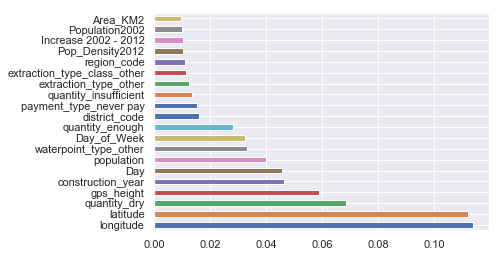

In [44]:
# fit baseline model
baseline = RandomForestClassifier(random_state = seed)
baseline = baseline.fit(X_train,y_train)

y_pred = baseline.predict(X_test) 

(pd.Series(baseline.feature_importances_, index=X.columns)
   .nlargest(20)
   .plot(kind='barh')) 

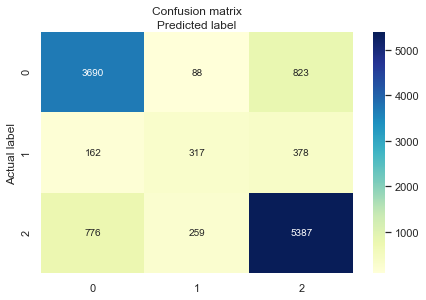

In [45]:
hf.confusion_heat_map(y_test, y_pred)

In [46]:
print('BASE LINE:')
print('Accuracy of Random Forest classifier on hold-out set: {:.3f}'.format(baseline.score(X_test, y_test)))
accuracy = cross_val_score(baseline, X, y.values.ravel(), scoring='accuracy', cv=5) 
print('Mean Accuracy after CV: {:.3f} +/- {:.03f}'.format(np.mean(accuracy), np.std(accuracy)))
print('Best Accuracy after CV: {:.3f}'.format(max(accuracy)))
print()
print(classification_report(y_test, y_pred))

BASE LINE:
Accuracy of Random Forest classifier on hold-out set: 0.791
Mean Accuracy after CV: 0.790 +/- 0.003
Best Accuracy after CV: 0.795

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      4601
           1       0.48      0.37      0.42       857
           2       0.82      0.84      0.83      6422

   micro avg       0.79      0.79      0.79     11880
   macro avg       0.70      0.67      0.68     11880
weighted avg       0.79      0.79      0.79     11880



## Custom Feature Engineering

In [47]:
fe_functions = ['operation_years']

engineering_data_total = X.join(y)
engineering_data_test = X_train.join(y_train)

funcs, new_dataset = hf.feature_engineering_pipeline(engineering_data_total, engineering_data_test, 
                                                     target, size, seed, fe_functions)

accuracy = hf.cv_evaluate(new_dataset, target, seed = seed)
print('Mean Accuracy after CV: {:.3f} +/- {:.03f}'.format(np.mean(accuracy), np.std(accuracy)))
print('Best Accuracy after CV: {:.3f}'.format(max(accuracy)))

Base Accuracy on Training Set: 0.7862
- New Accuracy (operation_years): 0.7825 [diff: -0.0037] [Accepted]
Mean Accuracy after CV: 0.794 +/- 0.006
Best Accuracy after CV: 0.802


In [48]:
scaled_numerics.append('operation_year')
# features = list(new_dataset)
# features.remove(target)

# dependent_var = [target]
# X = new_dataset.loc[:, features]
# y = new_dataset.loc[:, dependent_var]

# #Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=seed)

## Polynomial Features

In [49]:
pol = PolynomialFeatures(2)
pol_df = hf.operation_years(encoded_df)

pol_features = pol.fit_transform(pol_df[scaled_numerics])
pol_features = pd.DataFrame(hf.standardize2(pol_features))

print('{} features were created.'.format(pol.n_output_features_))

X = pol_features.join(encoded_df[features])
non_bool_numerics = pol_features.columns

#Create New Training Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=seed)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


300 features were created.


## Principal Component Analysis

Text(0, 0.5, 'cumulative explained variance')

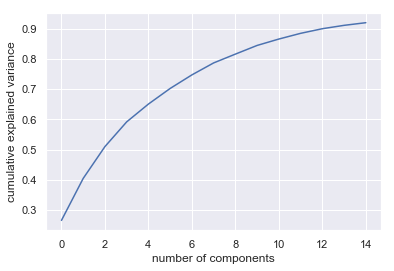

In [50]:
#Create PCA object for 15 components
pca = PCA(n_components = 15, random_state = seed)
pca.fit(X_train)

#Apply PCA to X train set and join with Y train set
X_pca_train = pd.DataFrame(pca.fit_transform(X_train[non_bool_numerics]))
PCA_train = X_pca_train.join(y_train)

#Apply PCA to X test set
X_pca_test = pd.DataFrame(pca.fit_transform(X_test[non_bool_numerics]))

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [51]:
# #Analyze different PCA combinations
# PCA_num = 10
# for x in range(0,PCA_num):
#     for y in range(1,PCA_num):
#         if x != y:
#             hf.pca_analysis(PCA_train, target, pca_1 = x, pca_2 = y, labels=[0,1,2], 
#             labl={0:'Non-Functional',1:'Repair',2:'Functional'})


## Boolean Feature Reduction

Optimal number of features: 105
Selected features: ['extraction_type_class_gravity', 'extraction_type_class_handpump', 'extraction_type_class_motorpump', 'extraction_type_class_other', 'extraction_type_class_rope pump', 'extraction_type_class_submersible', 'extraction_type_class_wind-powered', 'management_group_commercial', 'management_group_other', 'management_group_parastatal', 'management_group_unknown', 'management_group_user-group', 'source_dam', 'source_hand dtw', 'source_lake', 'source_machine dbh', 'source_other', 'source_rainwater harvesting', 'source_river', 'source_shallow well', 'source_spring', 'source_unknown', 'basin_Internal', 'basin_Lake Nyasa', 'basin_Lake Rukwa', 'basin_Lake Tanganyika', 'basin_Lake Victoria', 'basin_Pangani', 'basin_Rufiji', 'basin_Ruvuma / Southern Coast', 'basin_Wami / Ruvu', 'waterpoint_type_cattle trough', 'waterpoint_type_communal standpipe', 'waterpoint_type_communal standpipe multiple', 'waterpoint_type_dam', 'waterpoint_type_hand pump', 'wat

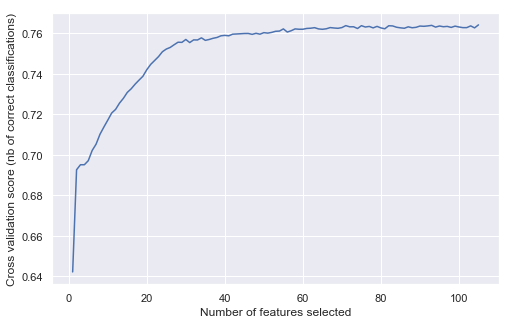

In [52]:
level_bools = hf.boolean_features(X_train)

X_bool = X.loc[:,level_bools].copy()
X_train_bool = X_train.loc[:,level_bools].copy()
X_test_bool = X_test.loc[:,level_bools].copy()
                             
X_optimized_bool, optimized_model = hf.feature_reduction(baseline,score_target = target_metric, 
                                                         cv_input = 5, X_entire_set = X_bool, 
                                                         X_train_set= X_train_bool,y_train_set = y_train)

## Identifying Functional Wells

In [53]:
y_functional_train = pd.DataFrame([1 if value == 2 else 0 for value in y_train.iloc[:,0]])
y_functional_train.columns = ['functional']

y_functional_test = pd.DataFrame([1 if value == 2 else 0 for value in y_test.iloc[:,0]])
y_functional_test.columns = ['functional']

y_functional_train.head()

,functional
0,1
1,0
2,0
3,1
4,1


In [251]:
#Combine PCA variables with boolean for first level training
X_train_bool = X_train_bool.loc[:,X_optimized_bool.columns]
X_test_bool = X_test_bool.loc[:,X_optimized_bool.columns]

X_stack_train = pd.concat([X_train_bool.reset_index(drop=True), X_pca_train], axis=1)
X_stack_test = pd.concat([X_test_bool.reset_index(drop=True), X_pca_test], axis=1)

X_stack_train.head()

,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered,management_group_commercial,management_group_other,management_group_parastatal,...,5,6,7,8,9,10,11,12,13,14
0,1,0,0,0,0,0,0,0,0,0,...,-4.514256,3.624798,1.584561,-3.432081,-0.312453,0.792430,0.687239,-1.843565,-1.385462,-1.519489
1,1,0,0,0,0,0,0,0,0,0,...,-3.750144,3.028694,-1.312579,2.209932,2.113956,-0.805553,3.417787,2.522373,1.514397,-0.729055
2,0,1,0,0,0,0,0,0,0,0,...,-1.402717,5.139288,-1.821910,0.021386,-5.320285,-2.647302,0.904789,-2.070250,-1.644316,-2.209424
3,0,0,0,0,1,0,0,0,0,0,...,1.698239,-4.508113,-1.581085,-1.215152,-0.083821,1.848273,-2.358832,-1.302074,2.456860,0.039138
4,1,0,0,0,0,0,0,0,0,0,...,1.087217,3.317735,-4.301221,-2.655281,-1.623079,0.439974,1.017628,-0.072428,-1.717543,0.439741


## Stack Models

In [55]:
model_1 = GradientBoostingClassifier(random_state = seed, max_features = 'auto')
model_2 = XGBClassifier(random_state = seed, gamma = 1)
model_3 = KNeighborsClassifier()

In [56]:
#Tune First Model
param_model_1 = {'n_estimators':range(100,200,50), 
                 'max_depth':range(2,5,1)}

gsearch1 = GridSearchCV(estimator = model_1, param_grid = param_model_1, 
                                    scoring='accuracy',n_jobs=4, cv=5)
gsearch1.fit(X_stack_train, y_functional_train)
tuned_func_model_1 = gsearch1.best_estimator_ 

print('='*20)
print("best params: " + str(gsearch1.best_estimator_))
print("best params: " + str(gsearch1.best_params_))
print('best score:', gsearch1.best_score_)
print('='*20)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


best params: GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              n_iter_no_change=None, presort='auto', random_state=12345,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
best params: {'max_depth': 4, 'n_estimators': 150}
best score: 0.7821969696969697


In [57]:
#Tune Second Model
param_model_2 = {'max_depth' : range(2,5,1)}

gsearch2 = GridSearchCV(estimator = model_2, param_grid = param_model_2, 
                                    scoring='accuracy',n_jobs=4, cv=5)
gsearch2.fit(X_stack_train, y_functional_train)
tuned_func_model_2 = gsearch2.best_estimator_ 

print('='*20)
print("best params: " + str(gsearch2.best_estimator_))
print("best params: " + str(gsearch2.best_params_))
print('best score:', gsearch2.best_score_)
print('='*20)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


best params: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=1, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=12345, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)
best params: {'max_depth': 4}
best score: 0.7705387205387205


In [58]:
#Tune Third Model
param_model_3 = {'n_neighbors':range(3, 7, 1)}
gsearch3 = GridSearchCV(estimator = model_3, param_grid = param_model_3, 
                                    scoring='accuracy',n_jobs=4, cv=5)
gsearch3.fit(X_stack_train, y_functional_train)
tuned_func_model_3 = gsearch3.best_estimator_ 

print('='*20)
print("best params: " + str(gsearch3.best_estimator_))
print("best params: " + str(gsearch3.best_params_))
print('best score:', gsearch3.best_score_)
print('='*20)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


best params: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')
best params: {'n_neighbors': 3}
best score: 0.7651515151515151


In [59]:
models_fun = [('gb', tuned_func_model_1), ('xgb', tuned_func_model_2), ('kn', tuned_func_model_3)]

stack_fun = StackingTransformer(estimators=models_fun, regression=False, stratified = True, n_folds=5, 
                            shuffle=True, random_state=seed, verbose = 2) 

stack_fun = stack_fun.fit(X_stack_train, y_functional_train)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
variant:      [A]
n_estimators: [3]

estimator  0: [et: GradientBoostingClassifier]
    fold  0:  [0.78442925]
    fold  1:  [0.77611783]
    fold  2:  [0.78261785]
    fold  3:  [0.78206882]
    fold  4:  [0.78217405]
    ----
    MEAN:     [0.78148156] + [0.00281333]

estimator  1: [rf: XGBClassifier]
    fold  0:  [0.77611783]
    fold  1:  [0.76538664]
    fold  2:  [0.76820286]
    fold  3:  [0.77586025]
    fold  4:  [0.77238767]
    ----
    MEAN:     [0.77159105] + [0.00422675]

estimator  2: [kn: KNeighborsClassifier]
    fold  0:  [0.76906891]
    fold  1:  [0.76538664]
    fold  2:  [0.76630892]
    fold  3:  [0.76628433]
    fold  4:  [0.76670525]
    ----
    MEAN:     [0.76675081] + [0.00123689]



In [60]:
S_train_fun = pd.DataFrame(stack_fun.transform(X_stack_train))
S_test_fun = pd.DataFrame(stack_fun.transform(X_stack_test))

Train set was detected.
Transforming...

estimator  0: [et: GradientBoostingClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    ----
    DONE

estimator  1: [rf: XGBClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    ----
    DONE

estimator  2: [kn: KNeighborsClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    ----
    DONE



## Identifying Non-Functional Wells

In [62]:
y_nonfunctional_train = pd.DataFrame([1 if value == 0 else 0 for value in y_train.iloc[:,0]])
y_nonfunctional_train.columns = ['nonfunctional']

y_nonfunctional_test = pd.DataFrame([1 if value == 0 else 0 for value in y_test.iloc[:,0]])
y_nonfunctional_test.columns = ['nonfunctional']

y_nonfunctional_train.head()

,nonfunctional
0,0
1,1
2,1
3,0
4,0


## Stack Models

In [63]:
#Tune First Model
gsearch1 = GridSearchCV(estimator = model_1, param_grid = param_model_1, 
                                    scoring='accuracy',n_jobs=4, cv=5)
gsearch1.fit(X_stack_train, y_nonfunctional_train)
tuned_non_func_model_1 = gsearch1.best_estimator_ 

print('='*20)
print("best params: " + str(gsearch1.best_estimator_))
print("best params: " + str(gsearch1.best_params_))
print('best score:', gsearch1.best_score_)
print('='*20)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


best params: GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              n_iter_no_change=None, presort='auto', random_state=12345,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
best params: {'max_depth': 4, 'n_estimators': 150}
best score: 0.8173400673400674


In [64]:
#Tune Second Model
gsearch2 = GridSearchCV(estimator = model_2, param_grid = param_model_2, 
                                    scoring='accuracy',n_jobs=4, cv=5)
gsearch2.fit(X_stack_train, y_nonfunctional_train)
tuned_non_func_model_2 = gsearch2.best_estimator_ 

print('='*20)
print("best params: " + str(gsearch2.best_estimator_))
print("best params: " + str(gsearch2.best_params_))
print('best score:', gsearch2.best_score_)
print('='*20)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


best params: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=1, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=12345, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)
best params: {'max_depth': 4}
best score: 0.8093855218855219


In [65]:
#Tune Third Model
gsearch3 = GridSearchCV(estimator = model_3, param_grid = param_model_3, 
                                    scoring='accuracy',n_jobs=4, cv=5)
gsearch3.fit(X_stack_train, y_nonfunctional_train)
tuned_non_func_model_3 = gsearch3.best_estimator_ 

print('='*20)
print("best params: " + str(gsearch3.best_estimator_))
print("best params: " + str(gsearch3.best_params_))
print('best score:', gsearch3.best_score_)
print('='*20)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


best params: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')
best params: {'n_neighbors': 3}
best score: 0.8001052188552189


In [66]:
models_non = [('et', tuned_non_func_model_1), ('rf', tuned_non_func_model_2), ('kn', tuned_non_func_model_3)]

stack_non = StackingTransformer(estimators=models_non, regression=False, stratified = True, n_folds=5, 
                            shuffle=True, random_state=seed, verbose = 2) 

stack_non = stack_non.fit(X_stack_train, y_nonfunctional_train)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
variant:      [A]
n_estimators: [3]

estimator  0: [et: GradientBoostingClassifier]
    fold  0:  [0.81420305]
    fold  1:  [0.81914782]
    fold  2:  [0.81839226]
    fold  3:  [0.81458487]
    fold  4:  [0.82058297]
    ----
    MEAN:     [0.81738219] + [0.00254223]

estimator  1: [rf: XGBClassifier]
    fold  0:  [0.80568122]
    fold  1:  [0.80704892]
    fold  2:  [0.80913300]
    fold  3:  [0.80869199]
    fold  4:  [0.81405872]
    ----
    MEAN:     [0.80892277] + [0.00284585]

estimator  2: [kn: KNeighborsClassifier]
    fold  0:  [0.80399790]
    fold  1:  [0.80231457]
    fold  2:  [0.80334596]
    fold  3:  [0.80353573]
    fold  4:  [0.79227612]
    ----
    MEAN:     [0.80109406] + [0.00444321]



In [67]:
S_train_non = pd.DataFrame(stack_non.transform(X_stack_train))
S_test_non = pd.DataFrame(stack_non.transform(X_stack_test))

Train set was detected.
Transforming...

estimator  0: [et: GradientBoostingClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    ----
    DONE

estimator  1: [rf: XGBClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    ----
    DONE

estimator  2: [kn: KNeighborsClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    ----
    DONE



## Identifying Functional with Repair

In [69]:
# y_repair_train = pd.DataFrame([1 if value == 1 else 0 for value in y_train.iloc[:,0]])
# y_repair_train.columns = ['repair']

# y_repair_test = pd.DataFrame([1 if value == 1 else 0 for value in y_test.iloc[:,0]])
# y_repair_test.columns = ['repair']

# y_repair_train.head()

In [70]:
## Stack Models

In [71]:
# #Tune First Model
# param_model_1 = {'n_estimators':range(100,200,50), 
#                  'max_depth':range(2,5,1)}

# gsearch1 = GridSearchCV(estimator = model_1, param_grid = param_model_1, 
#                                     scoring='accuracy',n_jobs=4, cv=5)
# gsearch1.fit(X_stack_train, y_repair_train)
# tuned_repair_model_1 = gsearch1.best_estimator_ 

# print('='*20)
# print("best params: " + str(gsearch1.best_estimator_))
# print("best params: " + str(gsearch1.best_params_))
# print('best score:', gsearch1.best_score_)
# print('='*20)

In [72]:
# #Tune Second Model
# param_model_2 = {'n_estimators': range(100, 200, 50),
#                  'max_depth' : range(2,5,1),
#                  'criterion' :['gini', 'entropy']}

# gsearch2 = GridSearchCV(estimator = model_2, param_grid = param_model_2, 
#                                     scoring='accuracy',n_jobs=4, cv=5)
# gsearch2.fit(X_stack_train, y_repair_train)
# tuned_repair_model_2 = gsearch2.best_estimator_ 

# print('='*20)
# print("best params: " + str(gsearch2.best_estimator_))
# print("best params: " + str(gsearch2.best_params_))
# print('best score:', gsearch2.best_score_)
# print('='*20)

In [73]:
# #Tune Third Model
# param_model_3 = {'n_neighbors':range(3, 7, 1)}
# gsearch3 = GridSearchCV(estimator = model_3, param_grid = param_model_3, 
#                                     scoring='accuracy',n_jobs=4, cv=5)
# gsearch3.fit(X_stack_train, y_repair_train)
# tuned_repair_model_3 = gsearch3.best_estimator_ 

# print('='*20)
# print("best params: " + str(gsearch3.best_estimator_))
# print("best params: " + str(gsearch3.best_params_))
# print('best score:', gsearch3.best_score_)
# print('='*20)

In [74]:
# models_repair = [('et', tuned_repair_model_1), ('rf', tuned_repair_model_2), ('kn', tuned_repair_model_3)]

# stack_repair = StackingTransformer(estimators=models_repair, regression=False, stratified = True, 
#                                    n_folds=5, shuffle=True, random_state=seed, verbose = 2) 

# stack_repair = stack_repair.fit(X_stack_train, y_repair_train)

In [75]:
# S_train_repair = pd.DataFrame(stack_repair.transform(X_stack_train))

In [76]:
# S_test_repair = pd.DataFrame(stack_repair.transform(X_stack_test))

## Combine in Final Model Layer

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


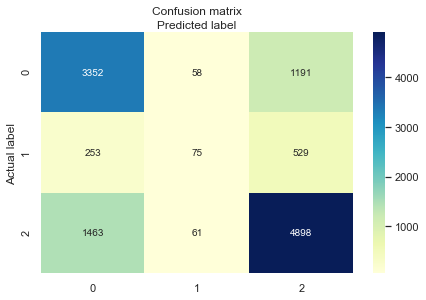

In [78]:
first_level_2 = RandomForestClassifier(random_state = seed, max_features = 'auto')

S_train_non.columns, S_test_non.columns = range(3,6,1), range(3,6,1)
# S_train_repair.columns, S_test_repair.columns = range(6,9,1), range(6,9,1)

S_train_full = S_train_fun.join(S_train_non)
S_test_full = S_test_fun.join(S_test_non)

# S_train_full = S_train.join(S_train_repair)
# S_test_full = S_test.join(S_test_repair)
    
first_level_2 = first_level_2.fit(S_train_full, y_train)
y_pred = first_level_2.predict(S_test_full)

hf.confusion_heat_map(y_test, y_pred)

In [79]:
print('Accuracy of Stacked Random Forest classifier on hold-out set: {:.3f}'.format(first_level_2.score(S_test_full, y_test)))
print(classification_report(y_test, y_pred))

Accuracy of Gradient Boosting classifier on hold-out set: 0.701
              precision    recall  f1-score   support

           0       0.66      0.73      0.69      4601
           1       0.39      0.09      0.14       857
           2       0.74      0.76      0.75      6422

   micro avg       0.70      0.70      0.70     11880
   macro avg       0.60      0.53      0.53     11880
weighted avg       0.68      0.70      0.68     11880



In [80]:
# #Tune Hyperparameters
# param_test1 = {'max_depth': range(2,5,1), 
#                'n_estimators': range(100, 200, 50),
#                'criterion' :['gini', 'entropy']}
# gsearch1 = GridSearchCV(estimator = RandomForestClassifier(random_state = seed), param_grid = param_test1, 
#                         scoring='accuracy',n_jobs=4, cv=5)
# gsearch1.fit(S_train_full,y_train)
# final_model = gsearch1.best_estimator_ 

# print('='*20)
# print("best params: " + str(gsearch1.best_estimator_))
# print("best params: " + str(gsearch1.best_params_))
# print('best score:', gsearch1.best_score_)
# print('='*20)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


best params: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, criterion='gini', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, max_features='auto',
       min_child_weight=1, missing=None, n_estimators=150, n_jobs=1,
       nthread=None, objective='multi:softprob', random_state=12345,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
best params: {'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 150}
best score: 0.7739688552188552


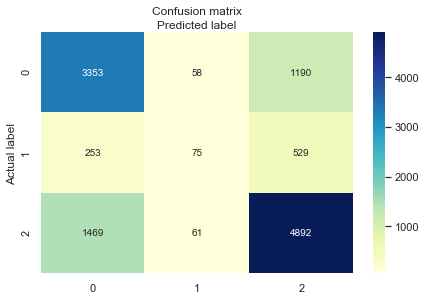

In [81]:
# y_pred = final_model.predict(S_test_full)
# hf.confusion_heat_map(y_test, y_pred)

In [82]:
# print('BASE LINE:')
# print('Accuracy of Gradient Boosting classifier on hold-out set: {:.3f}'.format(final_model.score(S_test_full, y_test)))
# print(classification_report(y_test, y_pred))

BASE LINE:
Accuracy of Gradient Boosting classifier on hold-out set: 0.700
              precision    recall  f1-score   support

           0       0.66      0.73      0.69      4601
           1       0.39      0.09      0.14       857
           2       0.74      0.76      0.75      6422

   micro avg       0.70      0.70      0.70     11880
   macro avg       0.60      0.53      0.53     11880
weighted avg       0.68      0.70      0.68     11880



## Test Data Processing and Modeling

In [216]:
#Parse date 
raw_test_df['date_recorded'] = pd.to_datetime(raw_test_df['date_recorded'])
raw_test_df['Year'], raw_test_df['Month'], raw_test_df['Day'], raw_test_df['Day_of_Week'] = raw_test_df['date_recorded'].dt.year, raw_test_df['date_recorded'].dt.month,raw_test_df['date_recorded'].dt.day,raw_test_df['date_recorded'].dt.weekday
raw_test_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,Year,Month,Day,Day_of_Week
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,2013,2,4,0
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,2013,2,4,0
2,17168,0.0,2013-02-01,,1567,,34.767863,-5.004344,Puma Secondary,0,...,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,2013,2,1,4
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,dry,shallow well,shallow well,groundwater,other,other,2013,1,22,1
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2013,3,27,2


In [217]:
#Merge with population data set
combined_test_df = pd.merge(raw_test_df, pop_df, how = 'left', left_on = 'region', 
                            right_on = 'Name')
combined_test_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,Day,Day_of_Week,Name,Status,Area_KM2,Population2002,Population2012,Increase 2002 - 2012,Pop_Density2012,Population2016
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,4,0,Manyara,Reg,44522,1037605,1425131,0.373481,32.009591,1618000
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,4,0,Arusha,Reg,37576,1288088,1694310,0.315368,45.090217,1890700
2,17168,0.0,2013-02-01,,1567,,34.767863,-5.004344,Puma Secondary,0,...,1,4,Singida,Reg,49340,1086748,1370637,0.261228,27.779428,1504000
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,22,1,Lindi,Reg,66040,787624,864652,0.097798,13.092853,897500
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,27,2,Ruvuma,Reg,63669,1113715,1376891,0.236305,21.625768,1498800


In [218]:
#Merge with weather data set
combined_test_df = pd.merge(combined_test_df, weather_df, how = 'left', left_on = 'Month', 
                       right_on = 'Month_num')
combined_test_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,Population2002,Population2012,Increase 2002 - 2012,Pop_Density2012,Population2016,Month_num,Temp_Min,Temp_max,rainy_days,total_rain_mm
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,1037605,1425131,0.373481,32.009591,1618000,2,18.6,29.4,9,144.5
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,1288088,1694310,0.315368,45.090217,1890700,2,18.6,29.4,9,144.5
2,17168,0.0,2013-02-01,,1567,,34.767863,-5.004344,Puma Secondary,0,...,1086748,1370637,0.261228,27.779428,1504000,2,18.6,29.4,9,144.5
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,787624,864652,0.097798,13.092853,897500,1,18.6,29.4,10,133.7
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,1113715,1376891,0.236305,21.625768,1498800,3,18.3,29.0,7,113.9


In [219]:
#Impute for construction year
combined_test_df.loc[combined_test_df['construction_year'] == 0, 'construction_year'] = combined_test_df['construction_year'].mean()

In [220]:
#Compute averages in districts within regions
region_district_mean = combined_test_df.groupby(['region','district_code']).mean()

region_district_mean_pop = pd.DataFrame(region_district_mean['population'])
region_district_mean_lat = pd.DataFrame(region_district_mean['latitude'])
region_district_mean_long = pd.DataFrame(region_district_mean['longitude'])

#Map based on district and region (multi-index dataframe)
for row in range(len(combined_test_df)):
    #Population
    if combined_test_df.loc[row, 'population'] == 0:
        combined_test_df.loc[row, 'population'] = region_district_mean_pop.loc[(combined_test_df.loc[row, 
                                                  'region'],combined_test_df.loc[row, 'district_code']), 
                                                  'population']
    #Latitude
    if combined_test_df.loc[row, 'latitude'] == 0:
        combined_test_df.loc[row, 'latitude'] = region_district_mean_lat.loc[(combined_test_df.loc[row, 
                                                'region'],combined_test_df.loc[row, 'district_code']), 
                                                'latitude']
    #Longitude
    if combined_test_df.loc[row, 'longitude'] == 0:
        combined_test_df.loc[row, 'longitude'] = region_district_mean_long.loc[(combined_test_df.loc[row, 
                                                 'region'],combined_test_df.loc[row, 'district_code']), 
                                                 'longitude']
combined_test_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,Population2002,Population2012,Increase 2002 - 2012,Pop_Density2012,Population2016,Month_num,Temp_Min,Temp_max,rainy_days,total_rain_mm
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,1037605,1425131,0.373481,32.009591,1618000,2,18.6,29.4,9,144.5
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,1288088,1694310,0.315368,45.090217,1890700,2,18.6,29.4,9,144.5
2,17168,0.0,2013-02-01,,1567,,34.767863,-5.004344,Puma Secondary,0,...,1086748,1370637,0.261228,27.779428,1504000,2,18.6,29.4,9,144.5
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,787624,864652,0.097798,13.092853,897500,1,18.6,29.4,10,133.7
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,1113715,1376891,0.236305,21.625768,1498800,3,18.3,29.0,7,113.9


In [222]:
#Determine which categorical variables to keep or drop based on number of unique values
cat.remove('status_group')
reduced_cat, large_drop, small_drop = hf.drop_categorical(combined_test_df, cat, upper_bound = up, 
                                                          lower_bound = low)

The following categories have too many unique values: ['subvillage', 'date_recorded', 'lga', 'region', 'installer', 'Name', 'ward', 'scheme_name', 'wpt_name', 'funder']
The following categories have too few unique values: ['recorded_by', 'Status']


In [223]:
# test_total_cat = reduced_cat.copy()
# for var in large_drop:
#     combined_df = hf.set_empty(combined_test_df, var)
#     test_total_cat.append(combined_test_df.columns[len(combined_test_df.columns)-1])

In [225]:
#Drop variables based on exploratory analysis
vars_to_drop.remove('status_group')
reduced_cat = [var for var in reduced_cat if var not in bool_to_drop]
scaled_numerics = [var for var in scaled_numerics if var not in nums_to_drop]

combined_test_df = combined_test_df.drop(vars_to_drop, axis = 1)

In [226]:
#Deal with LGA (rename all entries containing Rural and Urban)
combined_test_df.loc[combined_test_df['lga'].str.contains(' Rural'),'lga'] = 'rural'
combined_test_df.loc[combined_test_df['lga'].str.contains(' Urban'),'lga'] = 'urban'

#Otherwise rename as other
searchfor = ['rural', 'urban']
combined_test_df.loc[~combined_test_df['lga'].str.contains('|'.join(searchfor)),'lga'] = 'other'

reduced_cat.append('lga')
large_drop.remove('lga')

In [227]:
#Deal with extraction type
categorical_df.loc[categorical_df['extraction_type'].str.contains('|'.join(consolidate)),
                  'extraction_type'] = 'other motorpump'

In [228]:
#Create dummy variables for categorical variables
encoded_test_df = hf.onehot_encode(combined_test_df, reduced_cat)
encoded_test_df = encoded_test_df.drop(large_drop, axis = 1)
encoded_test_df = encoded_test_df.drop(small_drop, axis = 1)

encoded_test_df.head()

,gps_height,longitude,latitude,region_code,district_code,population,construction_year,Year,Month,Day,...,scheme_management_SWC,scheme_management_Trust,scheme_management_VWC,scheme_management_WUA,scheme_management_WUG,scheme_management_Water Board,scheme_management_Water authority,lga_other,lga_rural,lga_urban
0,1996,35.290799,-4.059696,21,3,321.0,2012.0,2013,2,4,...,0,0,0,0,0,0,0,1,0,0
1,1569,36.656709,-3.309214,2,2,300.0,2000.0,2013,2,4,...,0,0,1,0,0,0,0,0,1,0
2,1567,34.767863,-5.004344,13,2,500.0,2010.0,2013,2,1,...,0,0,1,0,0,0,0,0,1,0
3,267,38.058046,-9.418672,80,43,250.0,1987.0,2013,1,22,...,0,0,1,0,0,0,0,1,0,0
4,1260,35.006123,-10.950412,10,3,60.0,2000.0,2013,3,27,...,0,0,0,0,0,1,0,1,0,0


In [229]:
#Ensure test set columns match what model was trained with
train_col = X_baseline.columns
test_col = encoded_test_df.columns

X_baseline_test = encoded_test_df.copy()

for x in range(0,min(len(train_col),len(test_col))):
    if train_col[x] != test_col[x] and train_col[x] not in test_col:
        X_baseline_test[train_col[x]] = 0 * len(X_baseline_test.index)
    if train_col[x] != test_col[x] and test_col[x] not in train_col:
        X_baseline_test = X_baseline_test.drop(test_col[x], axis = 1)
        
X_baseline_test.head()

,gps_height,longitude,latitude,region_code,district_code,population,construction_year,Year,Month,Day,...,scheme_management_VWC,scheme_management_WUA,scheme_management_WUG,scheme_management_Water Board,scheme_management_Water authority,lga_other,lga_rural,lga_urban,extraction_type_other motorpump,scheme_management_None
0,1996,35.290799,-4.059696,21,3,321.0,2012.0,2013,2,4,...,0,0,0,0,0,1,0,0,0,0
1,1569,36.656709,-3.309214,2,2,300.0,2000.0,2013,2,4,...,1,0,0,0,0,0,1,0,0,0
2,1567,34.767863,-5.004344,13,2,500.0,2010.0,2013,2,1,...,1,0,0,0,0,0,1,0,0,0
3,267,38.058046,-9.418672,80,43,250.0,1987.0,2013,1,22,...,1,0,0,0,0,1,0,0,0,0
4,1260,35.006123,-10.950412,10,3,60.0,2000.0,2013,3,27,...,0,0,0,1,0,1,0,0,0,0


In [230]:
# ################################ Uncomment to debug #################################
# #####################################################################################
# #####################################################################################

# train_col = X_baseline.columns.sort_values()
# final_col = X_baseline_test.columns.sort_values()
# for x in range(0,len(final_col)):
#     print(train_col[x], final_col[x], train_col[x] == final_col[x])
    
#     if train_col[x] != final_col[x]:
#         print(train_col[x], final_col[x])

In [231]:
#Create CSV based on prediction from baseline model
X_baseline_final_test = pd.DataFrame(hf.standardize2(X_baseline_test))
y_baseline_test_pred = pd.DataFrame(baseline.predict(X_baseline_final_test))
y_baseline_test_pred.columns = [target]

#Merge prediction with original data set to map with id
baseline_raw_output = raw_test_df.join(y_baseline_test_pred)
baseline_raw_output = baseline_raw_output.loc[:,['id', target]]

#Undo scaling of target variable to revert to original format
baseline_clean_output = hf.undo_var_scaling(baseline_raw_output, target,new_col_name = 'status_group',  
                                cat = ['non functional', 'functional needs repair', 'functional'],
                                drop = True)

baseline_clean_output.to_csv("O-1-6_Submission_BASELINE.csv", index=False)
baseline_clean_output.head()

/Users/andrewmartinez/Documents/MBD/Machine Learning II/Group Project/Helper_Function.py:427: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  standardized_numericals = preprocessing.scale(df)


,id,status_group
0,50785,functional
1,51630,functional
2,17168,non functional
3,45559,non functional
4,49871,functional


In [282]:
#Polynomial Features
pol_test_df = hf.operation_years(encoded_test_df)
pol_test_features = pol.fit_transform(pol_test_df[scaled_numerics])
pol_test_features = pd.DataFrame(hf.standardize2(pol_test_features))

print('{} features were created.'.format(pol.n_output_features_))
pol_test_features.head()

276 features were created.


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


,0,1,2,3,4,5,6,7,8,9,...,266,267,268,269,270,271,272,273,274,275
0,0.0,1.939784,0.178035,0.552598,0.340936,-0.271504,0.276521,0.784311,1.131974,-0.791371,...,0.696675,0.656449,0.946702,1.047141,0.458960,0.943029,1.043773,1.045125,1.172055,1.264799
1,0.0,1.322052,0.425933,0.807803,-0.764310,-0.374879,0.231926,0.748858,1.131974,-0.791371,...,0.696675,0.656449,0.946702,1.047141,0.458960,0.943029,1.043773,1.045125,1.172055,1.264799
2,0.0,1.319159,0.083127,0.231366,-0.124431,-0.374879,0.656642,0.778402,1.131974,-0.791371,...,0.696675,0.656449,0.946702,1.047141,0.458960,0.943029,1.043773,1.045125,1.172055,1.264799
3,0.0,-0.561525,0.680261,-1.269746,3.773014,3.863497,0.125747,0.710449,1.131974,-1.120536,...,0.696675,0.656449,1.212318,0.861498,0.458960,1.208640,0.858052,1.586406,1.240946,0.898360
4,0.0,0.875028,0.126369,-1.790621,-0.298943,-0.271504,-0.277734,0.748858,1.131974,-0.462206,...,0.502874,0.406920,0.385480,0.489576,0.087644,0.386511,0.490916,0.133493,0.222309,0.300449


In [283]:
#Apply PCA to X train set and join with Y train set
X_pca_final = pol_test_features.copy()
X_pca_final = pd.DataFrame(pca.fit_transform(X_pca_final))

#Combine PCA variables with boolean for first level training
X_final_bool = encoded_test_df.copy()
                             
X_final = X_final_bool.join(X_pca_final)
X_final.head()

,gps_height,longitude,latitude,region_code,district_code,population,construction_year,Year,Month,Day,...,5,6,7,8,9,10,11,12,13,14
0,1996,35.290799,-4.059696,21,3,321.0,2012.0,2013,2,4,...,-1.189068,5.385674,2.844080,-4.434827,-1.628631,-4.676995,2.067872,-2.632232,1.387694,2.970009
1,1569,36.656709,-3.309214,2,2,300.0,2000.0,2013,2,4,...,0.150002,4.717301,4.478966,-3.294869,-0.527711,-0.376494,0.940949,-2.153415,-0.327339,1.247138
2,1567,34.767863,-5.004344,13,2,500.0,2010.0,2013,2,1,...,-2.518039,-1.590143,4.419136,-2.071776,-1.403274,-2.892897,1.814598,-1.455327,-0.230578,1.012037
3,267,38.058046,-9.418672,80,43,250.0,1987.0,2013,1,22,...,0.117462,4.793381,-1.768471,-1.300029,0.348202,-1.753516,0.325017,-1.513634,-2.986645,-2.860917
4,1260,35.006123,-10.950412,10,3,60.0,2000.0,2013,3,27,...,-1.603654,3.209959,-6.616858,1.107544,-0.539684,-1.281041,1.415560,1.135214,0.377452,-0.188318


In [285]:
#Ensure test set columns match what model was trained with
train_col = X_stack_train.columns
test_col = X_final.columns

X_final_test = X_final.copy()
for x in range(0,min(len(train_col),len(test_col))):
    if train_col[x] != test_col[x] and train_col[x] not in test_col:
        X_final_test[train_col[x]] = 0 * len(X_final_test.index)
    if train_col[x] != test_col[x] and test_col[x] not in train_col:
        X_final_test = X_final_test.drop(test_col[x], axis = 1)

#Final check to remove extraneous columns 
X_final_test = X_final_test.loc[:,train_col]
X_final_test.head()

,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered,management_group_commercial,management_group_other,management_group_parastatal,...,5,6,7,8,9,10,11,12,13,14
0,0,0,0,1,0,0,0,0,0,1,...,-1.189068,5.385674,2.844080,-4.434827,-1.628631,-4.676995,2.067872,-2.632232,1.387694,2.970009
1,1,0,0,0,0,0,0,0,0,0,...,0.150002,4.717301,4.478966,-3.294869,-0.527711,-0.376494,0.940949,-2.153415,-0.327339,1.247138
2,0,0,0,1,0,0,0,0,0,0,...,-2.518039,-1.590143,4.419136,-2.071776,-1.403274,-2.892897,1.814598,-1.455327,-0.230578,1.012037
3,0,0,0,1,0,0,0,0,0,0,...,0.117462,4.793381,-1.768471,-1.300029,0.348202,-1.753516,0.325017,-1.513634,-2.986645,-2.860917
4,1,0,0,0,0,0,0,0,0,0,...,-1.603654,3.209959,-6.616858,1.107544,-0.539684,-1.281041,1.415560,1.135214,0.377452,-0.188318


In [276]:
# ################################ Uncomment to debug #################################
# #####################################################################################
# #####################################################################################

# train_col = X_stack_train.columns
# final_col = X_final_test.columns

# for x in range(0,len(final_col)):
#     print(x, train_col[x], final_col[x], train_col[x] == final_col[x])
    
# #     if train_col[x] != final_col[x]:
# #         print(train_col[x], final_col[x])

In [288]:
S_test_func_final = pd.DataFrame(stack_fun.transform(X_final_test))
S_test_nonfunc_final = pd.DataFrame(stack_non.transform(X_final_test))
# S_test_repair_final = pd.DataFrame(stack_repair.transform(X_final))

Transforming...

estimator  0: [et: GradientBoostingClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    ----
    DONE

estimator  1: [rf: XGBClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    ----
    DONE

estimator  2: [kn: KNeighborsClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    ----
    DONE

Transforming...

estimator  0: [et: GradientBoostingClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    ----
    DONE

estimator  1: [rf: XGBClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold 

In [289]:
#Create CSV based on prediction from final model
S_test_nonfunc_final.columns =  range(3,6,1)
S_test_final = S_test_func_final.join(S_test_nonfunc_final)


y_final_test_pred = pd.DataFrame(final_model.predict(S_test_final))
y_final_test_pred.columns = [target]

#Merge prediction with original data set to map with id
final_raw_output = raw_test_df.join(y_final_test_pred)
final_raw_output = final_raw_output.loc[:,['id', target]]

#Undo scaling of target variable to revert to original format
final_clean_output = hf.undo_var_scaling(final_raw_output, target,new_col_name = 'status_group',  
                                cat = ['non functional', 'functional needs repair', 'functional'],
                                drop = True)

final_clean_output.to_csv("O-1-6_Submission_FINAL.csv", index=False)
final_clean_output.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [ ]:
# ################################ Uncomment to debug #################################
# #####################################################################################
# #####################################################################################

# y_debug = hf.categorical_to_scale(labels, 'status_group')
# y_debug_test = y_debug['func_band']      
# y_debug_test.head()

In [ ]:
# ################################ Uncomment to debug #################################
# #####################################################################################
# #####################################################################################

# hf.confusion_heat_map(y_debug_test, y_baseline_test_pred)

In [ ]:
# ################################ Uncomment to debug #################################
# #####################################################################################
# #####################################################################################

# print('BASE LINE:')
# print('Debug Accruacy: {:.2f}'.format(baseline.score(X_final_test, y_debug)))


In [ ]:
######################## Hide code in final report output ########################
##################################################################################
##################################################################################

# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# The raw code for this IPython notebook is by default hidden for easier reading.
# To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')